# **PyTorch Workflow Exercise - Solution**

In [1]:
# Import necessary libraries
import torch
import matplotlib.pyplot as plt
from torch import nn

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## **Q1 Create a straight line dataset using the linear regression formula (`weight * X + bias`)**
  * Set `weight=0.4` and `bias=0.7` there should be at least 100 datapoints total.
  * Split the data into 80% training, 20% testing.
  * Plot the training and testing data so it becomes visual.

In [3]:
# Create the data parameters
weight = 0.4
bias = 0.7
# Make X and y using linear regression feature
X = torch.arange(0,1,0.01).unsqueeze(dim = 1)
y = weight * X + bias
print(f"Number of X samples: {len(X)}")
print(f"Number of y samples: {len(y)}")
print(f"First 10 X & y samples:\nX: {X[:10]}\ny: {y[:10]}")

Number of X samples: 100
Number of y samples: 100
First 10 X & y samples:
X: tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900]])
y: tensor([[0.7000],
        [0.7040],
        [0.7080],
        [0.7120],
        [0.7160],
        [0.7200],
        [0.7240],
        [0.7280],
        [0.7320],
        [0.7360]])


In [4]:
# Split the data into training and testing
train_split = int(len(X) * 0.8)
X_train = X[:train_split]
y_train = y[:train_split]
X_test = X[train_split:]
y_test = y[train_split:]
len(X_train),len(y_train),len(X_test),len(y_test)

(80, 80, 20, 20)

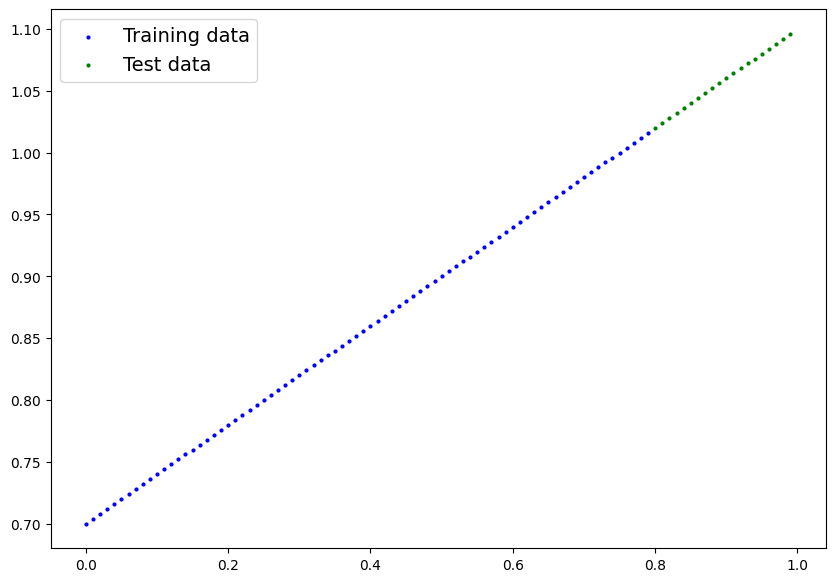

In [5]:
# Plot the training and testing data
def plot_predictions(train_data = X_train,
                 train_labels = y_train,
                 test_data = X_test,
                 test_labels = y_test,
                 predictions = None):
  plt.figure(figsize = (10,7))
  plt.scatter(train_data,train_labels,c = 'b',s = 4,label = "Training data")
  plt.scatter(test_data,test_labels,c = 'g',s = 4,label = "Test data")

  if predictions is not None:
    plt.scatter(test_data,predictions,c = 'r',s = 4,label = "Predictions")
  plt.legend(prop = {"size" : 14})
plot_predictions()

## **Q2 Build a PyTorch model by subclassing `nn.Module`**
  * Inside should be a randomly initialized `nn.Parameter()` with `requires_grad=True`, one for `weights` and one for `bias`
  * Implement the `forward()` method to compute the linear regression function you used to create the dataset in Q1
  * Once you've constructed the model, make an instance of it and check its `state_dict()`
  * **Note:** If you'd like to use `nn.Linear()` instead of `nn.Parameter()` you can

In [6]:
# Create PyTorch linear regression model by subclassing nn.Module
## Option 1
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(data=torch.randn(1,
                                              requires_grad=True,
                                              dtype=torch.float
                                              ))

    self.bias = nn.Parameter(data=torch.randn(1,
                                              requires_grad=True,
                                              dtype=torch.float
                                              ))

  def forward(self, x):
    return self.weight * x + self.bias

# ## Option 2
# class LinearRegressionModel(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.linear_layer = nn.Linear(in_features = 1,
#                                   out_features = 1)
#   def forward(self,x : torch.Tensor) -> torch.Tensor:
#     return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModel()
model_1,model_1.state_dict()

(LinearRegressionModel(),
 OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))]))

In [7]:
next(model_1.parameters()).device

device(type='cpu')

In [8]:
# Instantiate the model and put it to the target device
model_1.to(device)
list(model_1.parameters())

[Parameter containing:
 tensor([0.3367], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1288], device='cuda:0', requires_grad=True)]

## **Q3 Write the training loop with `MSE` as the loss function and `Adam` as optimizer**.
  * Set the learning rate of the optimizer to be 0.05 and the parameters to optimize should be the model parameters from the model you created in Q2
  * Write a training loop to perform the appropriate training steps for 100 epochs
  * The training loop should test the model on the test dataset every 10 epochs

In [9]:
# Create the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 0.05)

In [10]:
# Training loop
# Train model for 300 epochs
torch.manual_seed(42)

epochs = 100

# Send data to target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ### Training

  # Put model in train mode
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred,y_train)

  # 3. Zero gradients
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Perform testing every 30 epochs
  if epoch % 10 == 0:
    # Put model in evaluation mode and setup inference context
    model_1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      y_preds = model_1(X_test)
      # 2. Calculate test loss
      test_loss = loss_fn(y_preds,y_test)
      # Print out what's happening
      print(f"Epoch: {epoch} | Train loss: {loss:.3f} | Test loss: {test_loss:.3f}")

Epoch: 0 | Train loss: 0.356 | Test loss: 0.284
Epoch: 10 | Train loss: 0.008 | Test loss: 0.072
Epoch: 20 | Train loss: 0.028 | Test loss: 0.099
Epoch: 30 | Train loss: 0.005 | Test loss: 0.001
Epoch: 40 | Train loss: 0.003 | Test loss: 0.002
Epoch: 50 | Train loss: 0.002 | Test loss: 0.011
Epoch: 60 | Train loss: 0.000 | Test loss: 0.001
Epoch: 70 | Train loss: 0.000 | Test loss: 0.000
Epoch: 80 | Train loss: 0.000 | Test loss: 0.001
Epoch: 90 | Train loss: 0.000 | Test loss: 0.000


## **Q4 Make predictions with the trained model on the test data**
  * Visualize these predictions against the original training and testing data (**note:** you may need to make sure the predictions are *not* on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

In [11]:
# Make predictions with the model
model_1.eval()

with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[1.0221],
        [1.0262],
        [1.0302],
        [1.0343],
        [1.0384],
        [1.0424],
        [1.0465],
        [1.0506],
        [1.0546],
        [1.0587],
        [1.0627],
        [1.0668],
        [1.0709],
        [1.0749],
        [1.0790],
        [1.0831],
        [1.0871],
        [1.0912],
        [1.0953],
        [1.0993]], device='cuda:0')

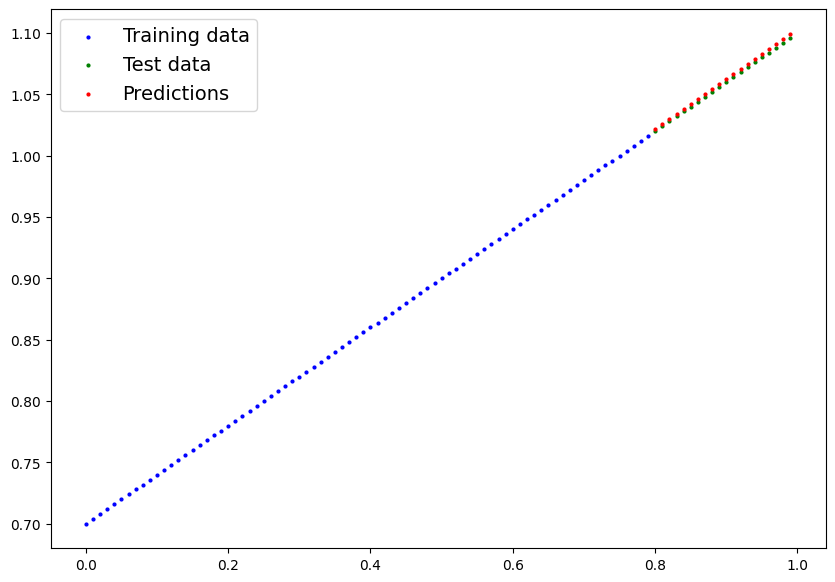

In [12]:
# Plot the predictions (these may need to be on a specific device)
plot_predictions(predictions = y_preds.cpu())

## **Q5 Save your trained model's `state_dict()` to file**
  * Create a new instance of your model class you made in 2. and load in the `state_dict()` you just saved to it.
  * Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [13]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True,exist_ok = True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_model"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj = model_1.state_dict(),f = MODEL_SAVE_PATH)

Saving model to models/01_pytorch_model


In [14]:
# Create new instance of model and load saved state dict (make sure to put it on the target device)
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH, weights_only=True))
loaded_model.to(device)

LinearRegressionModel()

In [15]:
# Make predictions with loaded model and compare them to the previous
y_preds_new = loaded_model(X_test)
y_preds == y_preds_new

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

In [16]:
loaded_model.state_dict()

OrderedDict([('weight', tensor([0.4065], device='cuda:0')),
             ('bias', tensor([0.6969], device='cuda:0'))])